In [1]:
# !pip install shapely

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import json
import numpy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay, Voronoi, SphericalVoronoi
from shapely.geometry import LineString, Polygon
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
from math import log2

In [3]:
f = open('data/230901K.json')
data = json.load(f)
ndata = numpy.asarray(data)
print("Data count : " + str(len(ndata)))
ndata

Data count : 365045


array([[ 25.03876915, 121.5294374 ,   2.23455172,  36.88836682],
       [ 25.03876915, 121.5294374 ,   4.46910345,  36.80608959],
       [ 25.03876915, 121.5294374 ,   6.70365517,  36.70825019],
       ...,
       [ 25.03954678, 121.5326636 ,  53.62924138,  35.60250566],
       [ 25.03954678, 121.5326636 ,  55.8637931 ,  35.62920659],
       [ 25.03954678, 121.5326636 ,  58.09834483,  35.7115966 ]])

In [4]:
vmax = ndata[:, 3].max()
vmin = ndata[:, 3].min()
print("Max num in value : " + str(vmax))
print("Min num in value : " + str(vmin))

Max num in value : 39.52869784427365
Min num in value : 33.89911573784602


In [5]:
# Set the hotspot value range to be retrieved, for example, 0.2 is the top 20% value.

getValueRange = 0.15

print("Find value greater than " + str(vmax - ((vmax - vmin) * getValueRange)))

Find value greater than 38.68426052830951


In [6]:
dx = ndata
dx = ndata[numpy.where(ndata[:, 3] > vmax - ((vmax - vmin) * getValueRange))]
print("Data count : " + str(len(dx)))
dx

Data count : 3126


array([[ 25.03903117, 121.52953902,   0.        ,  38.70182565],
       [ 25.03903963, 121.52953902,   0.        ,  38.77208939],
       [ 25.03903963, 121.52956442,   0.        ,  38.69775851],
       ...,
       [ 25.03915796, 121.53261279,   2.23455172,  38.70373499],
       [ 25.03916641, 121.53261279,   0.        ,  38.73873447],
       [ 25.03917487, 121.53261279,   0.        ,  38.69151499]])

In [7]:
# Retrieve coordinate data to prevent values from affecting the grouping results.

ndx = dx[:, 0:3]
ndx

array([[ 25.03903117, 121.52953902,   0.        ],
       [ 25.03903963, 121.52953902,   0.        ],
       [ 25.03903963, 121.52956442,   0.        ],
       ...,
       [ 25.03915796, 121.53261279,   2.23455172],
       [ 25.03916641, 121.53261279,   0.        ],
       [ 25.03917487, 121.53261279,   0.        ]])

In [8]:
# Normalize all fields from minimum value 0 to maximum value 1.

scaler = MinMaxScaler(feature_range=(0, 1)).fit(ndx)
ndx = scaler.transform(ndx)
ndx

array([[0.12931034, 0.        , 0.        ],
       [0.13793103, 0.        , 0.        ],
       [0.13793103, 0.00826446, 0.        ],
       ...,
       [0.25862069, 1.        , 0.25      ],
       [0.26724138, 1.        , 0.        ],
       [0.27586207, 1.        , 0.        ]])

In [9]:
# Set the k value iteration test range

k_rangeMax = 30

In [10]:
k_range = range(2, k_rangeMax)
scores = []
distortions = []

# Record the performance of the KMeans model built for each K value.

for i in k_range:
    kmeans = KMeans(n_clusters=i, init = "k-means++", n_init="auto", random_state = 0).fit(ndx)
    distortions.append(kmeans.inertia_) # SSE
    scores.append(silhouette_score(ndx, kmeans.predict(ndx))) # 2

In [11]:
# Find the largest silhouette coefficient to determine the K value.

selected_K = scores.index(max(scores)) + 2

print("The optimal K value is : " + str(selected_K), ", value is :" + str(scores[selected_K-2]))

The optimal K value is : 10 , value is :0.5749924164010195


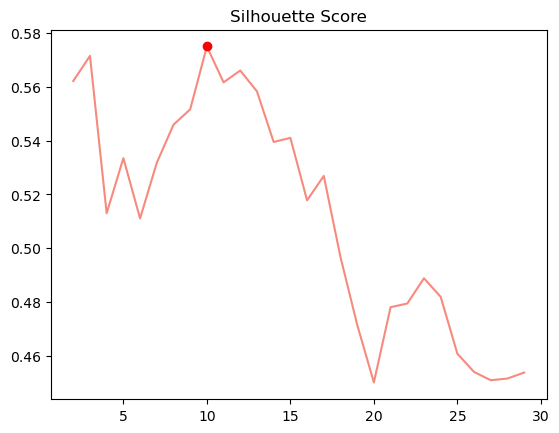

In [12]:
# Draw a silhouette function graph

plt.subplot()
plt.title('Silhouette Score')
plt.plot(k_range, scores, color="#f78a7e")
plt.plot(selected_K, scores[selected_K - 2], 'ro') # r = red, o=circle

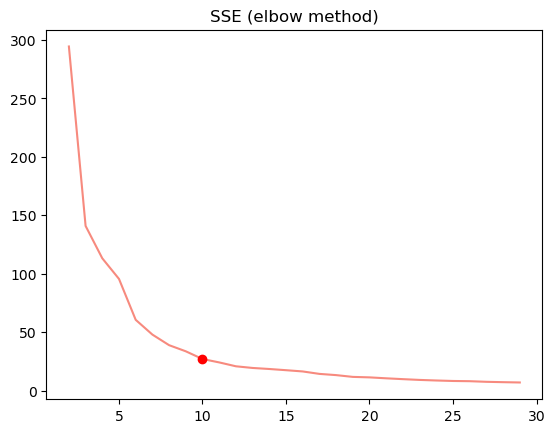

In [13]:
# Drawing the elbow diagram

plt.subplot()
plt.title('SSE (elbow method)')
plt.plot(k_range, distortions, color="#f78a7e")
plt.plot(selected_K, distortions[selected_K - 2], 'ro')

In [14]:
# Kmeans clustering

kmeans = KMeans(n_clusters = selected_K, init = "k-means++", n_init = "auto", random_state = 0)
kmeans.fit(ndx)
dy = kmeans.predict(ndx)
print("Grouping results :")
dy

Grouping results :


array([7, 7, 7, ..., 1, 6, 6])

In [15]:
# Center point of each group
centers = kmeans.cluster_centers_
print("Center point of each group :")
centers

Center point of each group :


array([[ 8.41722102e-01,  6.05925034e-01,  5.00000000e-01],
       [ 1.39984717e-01,  9.08220966e-01,  2.50000000e-01],
       [ 7.35402299e-01,  6.46005510e-01,  1.77635684e-15],
       [ 8.72341954e-01,  6.16138659e-01,  7.50000000e-01],
       [ 7.47139152e-01,  4.62846486e-01,  2.53318584e-01],
       [ 1.47902728e-01,  9.18558036e-01,  5.36380597e-01],
       [ 1.37869750e-01,  9.01844816e-01,  3.10862447e-15],
       [ 6.59545227e-01,  3.91543897e-01, -1.66533454e-16],
       [ 8.04070442e-01,  6.62951449e-01,  2.50000000e-01],
       [ 8.97724607e-01,  6.09883623e-01,  1.00000000e+00]])

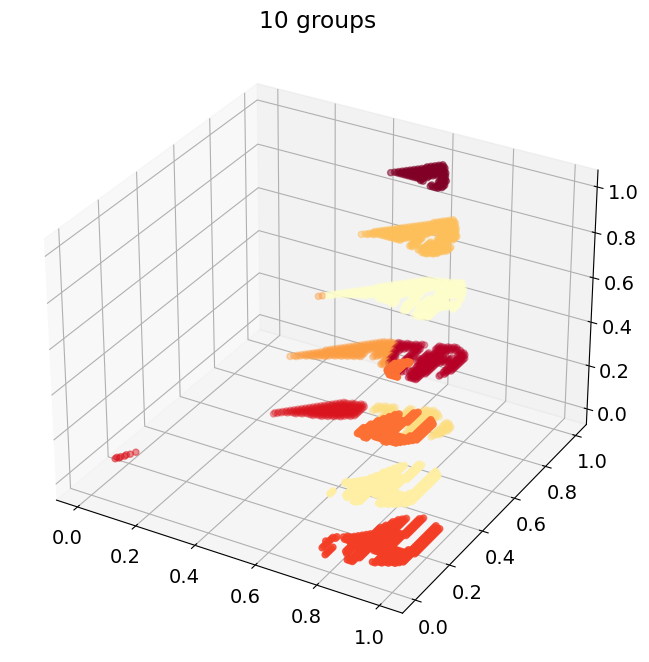

In [16]:
# Draw a graph of grouping results.

plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
plt.title(str(selected_K) + ' groups')
ax.scatter(ndx.T[1], ndx.T[0], ndx.T[2], c=dy, cmap="YlOrRd")

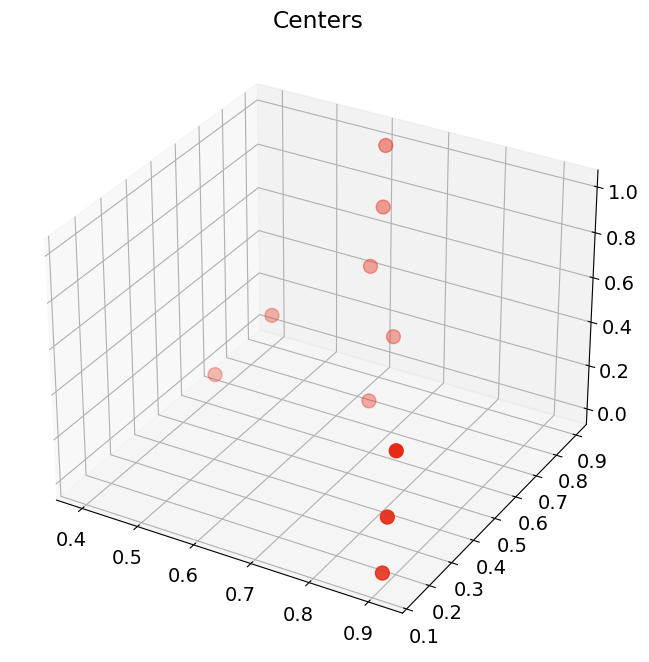

In [17]:
# Draw center diagrams of each group

plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Centers')
ax.scatter(centers.T[1], centers.T[0], centers.T[2], s=100, c="#e62a15")

In [18]:
# Add grouping results to each data.

dxList = dx.tolist()
dyList = dy.tolist()
if len(dxList) != len(dyList):
    print("Lengh error")
for i in range(len(dxList)):
    dxList[i].append(dyList[i])
dxList

[[25.039031173184352, 121.52953901550389, 0.0, 38.701825645619586, 7],
 [25.039039625698326, 121.52953901550389, 0.0, 38.77208938604653, 7],
 [25.039039625698326, 121.52956441860465, 0.0, 38.697758509051845, 7],
 [25.03904807821229, 121.52956441860465, 0.0, 38.741258329729554, 7],
 [25.039056530726256, 121.52958982170543, 0.0, 38.711256132036716, 7],
 [25.039064983240223, 121.52958982170543, 0.0, 38.74271813164357, 7],
 [25.03907343575419, 121.52961522480621, 0.0, 38.71206860335513, 7],
 [25.03909034078212, 121.52964062790699, 0.0, 38.70787105980991, 7],
 [25.039470703910613, 121.53037731782946, 0.0, 38.68480826878685, 7],
 [25.03947915642458, 121.53037731782946, 0.0, 38.75728276528919, 7],
 [25.03947915642458, 121.53040272093024, 0.0, 38.70241850098718, 7],
 [25.039487608938547, 121.53040272093024, 0.0, 38.7635786772638, 7],
 [25.039487608938547, 121.53042812403102, 0.0, 38.72066959750884, 7],
 [25.03949606145251, 121.53042812403102, 0.0, 38.777650783830246, 7],
 [25.03949606145251, 1

In [19]:
# Restore center point coordinates.

centers_inverse = scaler.inverse_transform(centers)
centers_inverse

array([[ 2.50397297e+01,  1.21531401e+02,  4.46910345e+00],
       [ 2.50390416e+01,  1.21532331e+02,  2.23455172e+00],
       [ 2.50396254e+01,  1.21531525e+02,  1.58774450e-14],
       [ 2.50397597e+01,  1.21531433e+02,  6.70365517e+00],
       [ 2.50396369e+01,  1.21530962e+02,  2.26421392e+00],
       [ 2.50390494e+01,  1.21532362e+02,  4.79428075e+00],
       [ 2.50390396e+01,  1.21532311e+02,  2.77855287e-14],
       [ 2.50395511e+01,  1.21530743e+02, -1.48851046e-15],
       [ 2.50396928e+01,  1.21531577e+02,  2.23455172e+00],
       [ 2.50397846e+01,  1.21531414e+02,  8.93820690e+00]])

In [20]:
### Delaunay's triangulation ###

# Function that defines whether a polygon intersects a line.

def line_intersects_cylinder(line_start, line_end, polygon_vertices, height):
    polygon = Polygon(polygon_vertices)
    line = LineString([line_start, line_end])
    
    # Check the number of intersections of a line segment and a polygon.
    
    intersection_points = line.intersection(polygon)
    if intersection_points.is_empty:
        return False
    elif intersection_points.geom_type == 'LineString':
        return 0 <= intersection_points.coords[0][2] <= height or 0 <= intersection_points.coords[1][2] <= height
    elif intersection_points.geom_type == 'MultiLineString':
        for point in intersection_points.geoms:
            if 0 <= point.coords[0][2] <= height or 0 <= point.coords[1][2] <= height:
                return True
      
        return False
    else:
        return False

In [31]:
# Calculate connecting lines in Delaunay triangulation.

cPoints = numpy.array(centers_inverse)[:, 0:3]
tri = Delaunay(cPoints)
triPoints = cPoints[tri.simplices]
triPoints = triPoints.tolist()
lines = []
# Exclude identical line segments with opposite starting and ending points.
for triPoint in triPoints:
    for i in range(len(triPoint)):
        startPoint = []
        endPoint = []
        if i == len(triPoint) - 1:
            startPoint = triPoint[i]
            endPoint = triPoint[0]
        else:
            startPoint = triPoint[i]
            endPoint = triPoint[i + 1]
        
        l = [startPoint, endPoint]
        shouldAdd = True
        a = LineString(l)
        for line in lines:
            b = LineString(line)
            if a.equals(b):
                should = False                      
        if shouldAdd:
            lines.append(l)

print("After Delaunay triangulation and deducting equal line segments, the total number of line segments is: " + str(len(lines)))

After Delaunay triangulation and deducting equal line segments, the total number of line segments is: 64


In [32]:
# Read building information and exclude line segments that intersect with buildings

buildingsData = json.load(open('data/buildings.json'))
newLines = []
for line in lines:
    sa = True
    for feature in buildingsData['features']:
        height = feature['properties']['height']
        coords = feature['geometry']['coordinates'][0]
        if line_intersects_cylinder(line[0], line[1], coords, height):
            sa = False
    if sa:
        sa2 = True
        for newLine in newLines:
            a = LineString(line)
            b = LineString(newLine)
            if a.equals(b):
                sa2 = False
        if sa2:
            newLines.append(line)
            
# A warning will be issued if there is no intersection.

print("After excluding the line segments that intersect with the building, the total number of line segments is: " + str(len(newLines)))

After excluding the line segments that intersect with the building, the total number of line segments is: 30


In [33]:
### Perform Space Syntax calculations ###

In [34]:
# Create network diagram

G = nx.Graph()

# Join nodes

for i in range(len(cPoints)):
    G.add_node(i + 1)
    
# Add connection line

def getIndexOfPoint(coords, points):
    for i in range(len(points)):
        if coords == points[i]:
            return i + 1
    print("error!")
    return -999

for edge in newLines:
    ai = getIndexOfPoint(edge[0], cPoints.tolist())
    bi = getIndexOfPoint(edge[1], cPoints.tolist())
    G.add_edge(ai, bi)

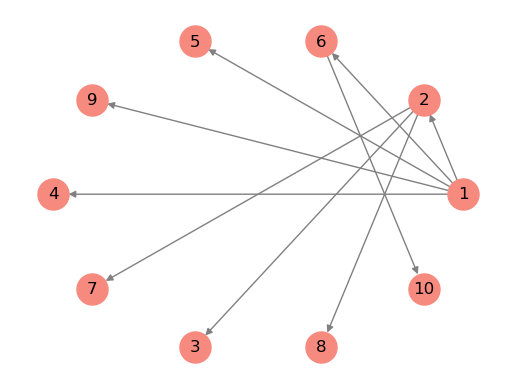

In [35]:
# Draw spatial relationship diagrams.

# Set the starting node (space).
start_node = 1

subgraph = nx.bfs_tree(G, start_node)
pos = nx.circular_layout(subgraph)
nx.draw_networkx(subgraph, pos=pos, with_labels=True, node_color='#f78a7e', node_size=500, font_size=12, font_color='black', edge_color='gray', arrows=True)
plt.axis('off')
plt.show()

In [36]:
# Calculate the number of levels from the starting node to other points.
levels = nx.shortest_path_length(G, start_node)

for node, level in levels.items():
    print(f'Number of levels of node {node}: {level}')

Number of levels of node 1: 0
Number of levels of node 2: 1
Number of levels of node 6: 1
Number of levels of node 5: 1
Number of levels of node 9: 1
Number of levels of node 4: 1
Number of levels of node 7: 2
Number of levels of node 3: 2
Number of levels of node 8: 2
Number of levels of node 10: 2


In [38]:
# Define a convenient value function for computing Space Syntax
# K: Total amount of space

def calcIntergrationValue(deep, K):
    MD = deep / (K - 1)
    RA = 2*(MD -1)/(K - 2)
    Dk = 2*(K*(log2((K + 2) / 3) - 1) + 1)/((K - 1)*(K - 2))
    RRA = RA / Dk
    # Integartion Value
    IV = 1 / RRA
    return IV

# Define a convenience value function for calculating all points. When isGlobal is False, calculate the local convenience value.

def getIV(mG, isGlobal):  
    totalIV = 0
    result = {}
    for i in range(mG.number_of_nodes()):
        data = nx.shortest_path_length(mG, i+1)
        deep = 0
        for node, level in data.items():
            if isGlobal is False and level > 3:
                break
            deep += level
        IV = calcIntergrationValue(deep, len(levels))
#         result[str(i+1)] = round(IV, 2)
        result[str(i+1)] = IV
    return result

In [39]:
# Calculate the integration value of all spaces

r = getIV(G, True)

# Sort from largest to smallest

sorted_r = sorted(r.items(), key=lambda x:x[1], reverse = True)
sorted_r

[('5', 10.999999999999996),
 ('6', 10.999999999999996),
 ('2', 5.499999999999998),
 ('8', 5.499999999999998),
 ('9', 5.499999999999998),
 ('1', 2.7500000000000004),
 ('4', 2.7500000000000004),
 ('7', 2.7500000000000004),
 ('3', 2.2),
 ('10', 2.2)]

In [48]:
rr = {"data": dxList, "centers": centers_inverse.tolist(), "lines": newLines, "iv": r}
with open('data/result.json', 'w') as f:
    json.dump(rr, f)

In [50]:
len(centers_inverse)

10